In [246]:
import numpy as np

from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gymnasium as gym

# Hugging Face Hub
from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.
import imageio

from functions.huggingface_course import record_video

In [247]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [248]:
env_id = "CartPole-v1"
env = gym.make(env_id, render_mode="rgb_array")

In [249]:
state, _ = env.reset()
img = torch.from_numpy(env.render())

In [250]:
def get_compressed_render(img: torch.TensorType) -> torch.TensorType:
    img = img.float().mean(dim=2)
    compressed_img = F.interpolate(img.view(1, 1, *img.shape), size=(48, 64), mode='bilinear', align_corners=False)

    return compressed_img

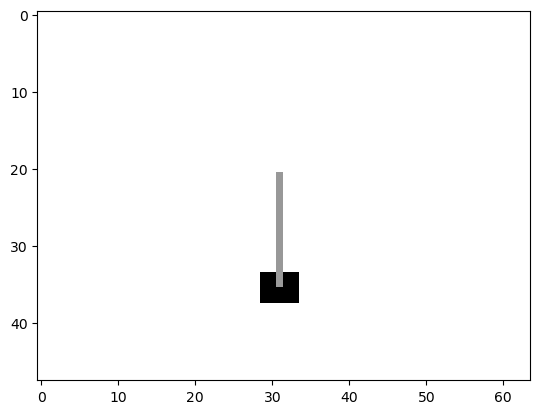

In [251]:
plt.imshow(get_compressed_render(img).squeeze(), cmap="gray")

In [252]:
s_size = env.observation_space.shape[0]
a_size = 2

In [253]:
env.observation_space.sample().shape

(4,)

In [254]:
def initialize_stack(env, stack_size: int = 3):
    image_list = []
    _ = env.reset()
    for _ in range(stack_size): 
        render = env.render()
        render = get_compressed_render(torch.from_numpy(render).float()).squeeze(0)

        image_list.append(render)

        _, _, _, _, _ = env.step(env.action_space.sample())

    image_stack = torch.stack(image_list, dim=1).to(device)

    return image_stack


In [255]:
class Policy(nn.Module):
    def __init__(self, a_size):
        super(Policy, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(4, 2)
        # Calculate the size here
        self.fc1 = nn.Linear(4480, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, a_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.flatten()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=0)
        return x

    def act(self, render):
        """
        Given a state, take action
        """
        probs = self.forward(render)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [256]:
policy = Policy(a_size).to(device)

img_stack = initialize_stack(env)
policy.act(img_stack)

(0, tensor(-0.0244, device='cuda:0', grad_fn=<SqueezeBackward1>))

In [257]:
def queue_new_render(env, img_stack: torch.TensorType):
    render = env.render()
    render = get_compressed_render(torch.from_numpy(render).float()).squeeze(0)

    new_stack = img_stack.clone()

    new_stack[:, :-1, :, :] = new_stack.clone()[:, 1:, :, :]
    new_stack[:, -1, :, :] = render 

    return new_stack

In [258]:
new_stack = queue_new_render(env, img_stack)

In [259]:
policy.act(new_stack)

(0, tensor(-0.0326, device='cuda:0', grad_fn=<SqueezeBackward1>))

In [260]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []
    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        img_stack = initialize_stack(env)
        # Line 4 of pseudocode
        for t in range(max_t):
            action, log_prob = policy.act(img_stack)
            saved_log_probs.append(log_prob)
            state, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)
            
            img_stack = queue_new_render(env, img_stack)

            if terminated or truncated:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)
        # Compute the discounted returns at each timestep,
        # as the sum of the gamma-discounted return at time t (G_t) + the reward at time t

        # In O(N) time, where N is the number of time steps
        # (this definition of the discounted return G_t follows the definition of this quantity
        # shown at page 44 of Sutton&Barto 2017 2nd draft)
        # G_t = r_(t+1) + r_(t+2) + ...

        # Given this formulation, the returns at each timestep t can be computed
        # by re-using the computed future returns G_(t+1) to compute the current return G_t
        # G_t = r_(t+1) + gamma*G_(t+1)
        # G_(t-1) = r_t + gamma* G_t
        # (this follows a dynamic programming approach, with which we memorize solutions in order
        # to avoid computing them multiple times)

        # This is correct since the above is equivalent to (see also page 46 of Sutton&Barto 2017 2nd draft)
        # G_(t-1) = r_t + gamma*r_(t+1) + gamma*gamma*r_(t+2) + ...


        ## Given the above, we calculate the returns at timestep t as:
        #               gamma[t] * return[t] + reward[t]
        #
        ## We compute this starting from the last timestep to the first, in order
        ## to employ the formula presented above and avoid redundant computations that would be needed
        ## if we were to do it from first to last.

        ## Hence, the queue "returns" will hold the returns in chronological order, from t=0 to t=n_steps
        ## thanks to the appendleft() function which allows to append to the position 0 in constant time O(1)
        ## a normal python list would instead require O(N) to do this.
        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft(rewards[t] + gamma * disc_return_t) # TODO: complete here

        ## standardization of the returns is employed to make training more stable
        eps = np.finfo(np.float32).eps.item()

        ## eps is the smallest representable float, which is
        # added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)

        policy_loss = torch.cat([loss.unsqueeze(0) for loss in policy_loss]).sum()

        # Line 8: PyTorch prefers gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores

In [261]:
cartpole_hyperparameters = {
    "h_size": 128,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 0.95,
    "lr": 2e-4,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [262]:
# Create policy and place it to the device
cartpole_policy = Policy(
    cartpole_hyperparameters["action_space"],
).to(device)
cartpole_optimizer = optim.Adam(cartpole_policy.parameters(), lr=cartpole_hyperparameters["lr"])

In [263]:
scores = reinforce(
    cartpole_policy,
    cartpole_optimizer,
    cartpole_hyperparameters["n_training_episodes"],
    cartpole_hyperparameters["max_t"],
    cartpole_hyperparameters["gamma"],
    100,
)

Episode 100	Average Score: 9.49
Episode 200	Average Score: 9.29
Episode 300	Average Score: 9.58
Episode 400	Average Score: 9.27
Episode 500	Average Score: 9.58
Episode 600	Average Score: 9.67
Episode 700	Average Score: 10.02
Episode 800	Average Score: 9.27


KeyboardInterrupt: 

In [102]:
def record_video(env, policy, out_directory, fps=30):
    """
    Generate a replay video of the agent
    :param env
    :param Qtable: Qtable of our agent
    :param out_directory
    :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
    """
    images = []
    state = env.reset()[0]
    img = env.render()
    images.append(img)
    terminated = False 

    while not terminated:
        # Take the action (index) that have the maximum expected future reward given that state
        action, _ = policy.act(state)
        state, reward, terminated, truncated, _ = env.step(action)  # We directly put next_state = state for recording logic
        img = env.render()
        images.append(img)
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [103]:
record_video(env, cartpole_policy, "./data/cartpole_v0.mp4")